In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import shutil
import datetime
import gc
from tqdm import tqdm

import pandas as pd
import numpy as np
from numpy import median

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from sklearn.manifold import TSNE
from sklearn import preprocessing

from collections import Counter

import string
import re
from nltk.corpus import stopwords

import scipy
from scipy import hstack


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from sklearn.linear_model import Ridge

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss

from sklearn.model_selection import RandomizedSearchCV 
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

In [3]:
train_data = pd.read_csv('./Data/final_data/train.tsv', sep='\t')
test_data = pd.read_csv('./Data/final_data/test.tsv', sep='\t')

In [4]:
print('Shape of train data: ', train_data.shape)
print('Shape of test data: ', test_data.shape)
train_data.head(5)

Shape of train data:  (1482535, 8)
Shape of test data:  (3460725, 7)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


### Handle missing data

In [5]:
def handle_category(data):
  """this function splits the category_name into further three sub_categories."""
  cat1=[]
  cat2=[]
  cat3=[]
  i=0
  for row in data:
    try:
      categories=row.split('/')
    except:
      categories=['','','']
    cat1.append(categories[0])
    cat2.append(categories[1])
    cat3.append(categories[2])
    i+=1
  return cat1,cat2,cat3
     

In [6]:
c1,c2,c3=handle_category(train_data['category_name'])
train_data['sub_category1']=c1
train_data['sub_category2']=c2
train_data['sub_category3']=c3
c1,c2,c3=handle_category(test_data['category_name'])
test_data['sub_category1']=c1
test_data['sub_category2']=c2
test_data['sub_category3']=c3

In [7]:
train_data['item_description'].fillna(value='No description given',inplace=True)
train_data['brand_name'].fillna(value='Not known',inplace=True)
train_data.isnull().sum()

train_id                0
name                    0
item_condition_id       0
category_name        6327
brand_name              0
price                   0
shipping                0
item_description        0
sub_category1           0
sub_category2           0
sub_category3           0
dtype: int64

In [8]:
train_data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,sub_category1,sub_category2,sub_category3
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,Not known,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,Not known,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,Not known,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


Number of Unique Category1: 11


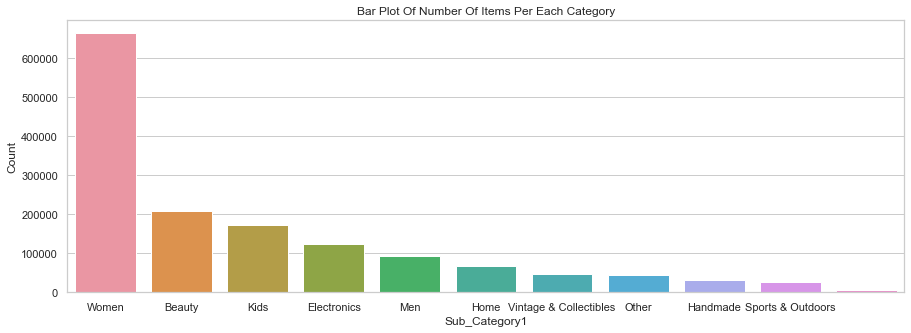

In [9]:
#subcategory1
count=train_data['sub_category1'].value_counts()
print("Number of Unique Category1: {}".format(len(count)))
plt.figure(figsize=(15,5))
sns.barplot(count.index,count)
plt.title("Bar Plot Of Number Of Items Per Each Category")
plt.xlabel('Sub_Category1')
plt.ylabel('Count')
plt.show()

Number Of Unique Category2: 114


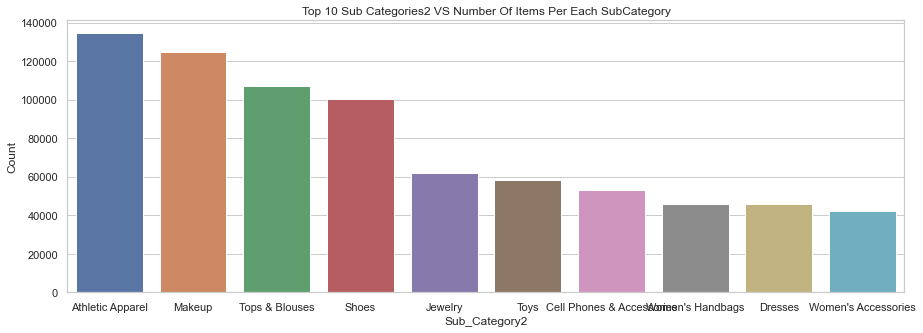

In [10]:
#sub-category2
count=train_data['sub_category2'].value_counts()
print("Number Of Unique Category2: {}".format(len(count)))
plt.figure(figsize=(15,5))
sns.barplot(count.index[:10],count[:10])
plt.xlabel('Sub_Category2')
plt.ylabel('Count')
plt.title("Top 10 Sub Categories2 VS Number Of Items Per Each SubCategory")
plt.show()

Number Of Unique Category3: 871


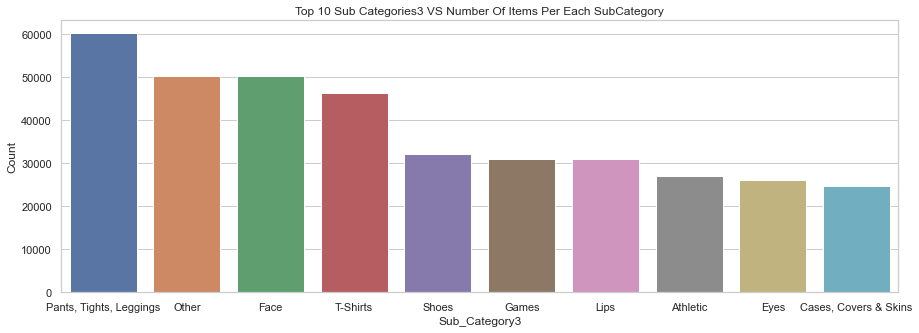

In [11]:
count=train_data['sub_category3'].value_counts()
print("Number Of Unique Category3: {}".format(len(count)))
plt.figure(figsize=(15,5))
sns.barplot(count.index[:10],count[:10])
plt.xlabel('Sub_Category3')
plt.ylabel('Count')
plt.title("Top 10 Sub Categories3 VS Number Of Items Per Each SubCategory")
plt.show()

In [12]:
train_data[train_data.duplicated()] #checking for duplicated rows

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,sub_category1,sub_category2,sub_category3


In [13]:
#checking rows with invalid prices
print('Removed {} rows' .format(len(train_data[train_data.price<=0])))
train_data = train_data[train_data.price > 0].reset_index(drop=True)

Removed 874 rows


In [14]:
train_data.name.describe()

count     1481661
unique    1224596
top        Bundle
freq         2232
Name: name, dtype: object

In [15]:
train_data.item_condition_id.describe()

count    1.481661e+06
mean     1.907322e+00
std      9.031759e-01
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      5.000000e+00
Name: item_condition_id, dtype: float64

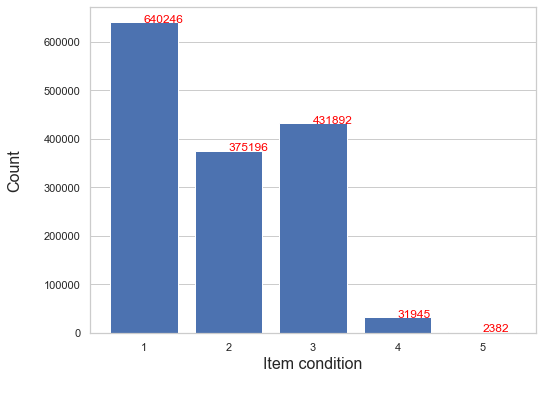

In [16]:
condition_count = Counter(list(train_data.item_condition_id))
x, y = zip(*condition_count.most_common())
plt.figure(figsize=[8,6])
plt.bar(x, y, )
for i, val in enumerate(y):
           plt.annotate(val, (x[i], y[i]), color='red')
plt.xlabel('Item condition\n', size = 16)
plt.ylabel('Count\n', size = 16)
plt.grid(False, axis='x')
plt.show()


In [17]:
train_data.brand_name.describe() #overview of brand_name

count       1481661
unique         4808
top       Not known
freq         632336
Name: brand_name, dtype: object

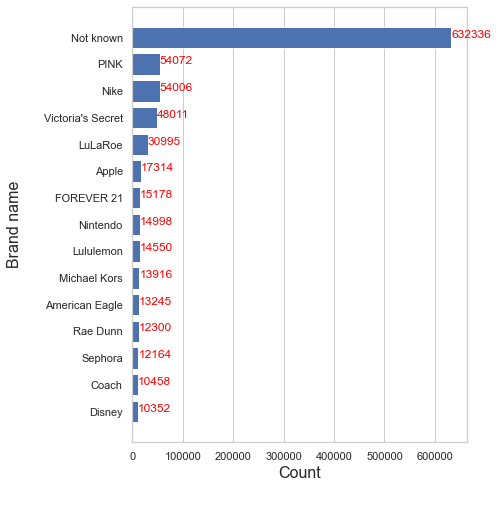

In [18]:
brand_count = Counter(list(train_data.brand_name.values))
x, y = zip(*brand_count.most_common(15))

plt.figure(figsize=[6,8])
plt.barh(x, y)
for i, val in enumerate(y):
           plt.annotate(val, (y[i], x[i]), color='red')
plt.gca().invert_yaxis()
plt.ylabel('Brand name\n', size = 16)
plt.xlabel('Count\n', size = 16)
plt.grid(False, axis='y')
plt.show()

In [19]:
brand_missing = train_data[train_data.brand_name=='Not known'].shape[0]
print('Brand name is missing for {} datapoints, i.e. {:.2f} % of train data.' .format(brand_missing, 100.0*brand_missing/train_data.shape[0]))


Brand name is missing for 632336 datapoints, i.e. 42.68 % of train data.


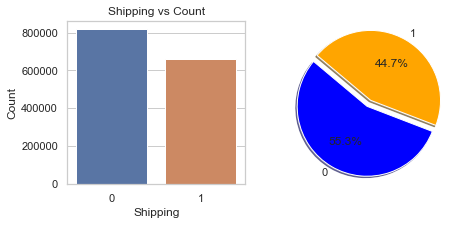

In [20]:
#Item shipping
count=train_data['shipping'].value_counts()
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
sns.barplot(count.index,count)
plt.xlabel('Shipping')
plt.ylabel('Count')
plt.title('Shipping vs Count')
plt.subplot(1,2,2)
labels = ['0','1']
sizes = count
colors = ['blue','orange']
explode = (0.1, 0)  # explode 1st slice
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

In [21]:
stopwords=set(stopwords.words('english'))

In [22]:
def stopwords_count(data):
    """Counts the number of stopwords in each item_description."""
    count_stopwords = []
    for i in tqdm(data['item_description']):
        count = 0
        if isinstance(i, str):  # Safe check for strings
            for j in i.split(' '):
                if j in stopwords:
                    count += 1
        count_stopwords.append(count)
    return count_stopwords


In [23]:
train_data['count_stopwords']=stopwords_count(train_data)
test_data['count_stopwords']=stopwords_count(test_data)

100%|█████████████████████████████| 3460725/3460725 [00:11<00:00, 310096.66it/s]


In [24]:
train_data['count_stopwords'].describe()

count    1.481661e+06
mean     5.978051e+00
std      9.058222e+00
min      0.000000e+00
25%      0.000000e+00
50%      3.000000e+00
75%      8.000000e+00
max      1.180000e+02
Name: count_stopwords, dtype: float64

In [25]:
def decontracted(phrase):
    """this function removies shorthands for the textual data..."""
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [26]:
def text_preprocessing(data):
    """This function performs preprocessing on item_description."""
    preprocessed_total = []
    for sentence in tqdm(data['item_description'].values):
        if not isinstance(sentence, str):
            sentence = ""
        sent = decontracted(sentence)
        sent = sent.replace('\r', ' ')
        sent = sent.replace('\"', ' ')
        sent = sent.replace('\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)  # remove stopwords
        preprocessed_total.append(sent.lower().strip())
    return preprocessed_total


In [27]:
train_data['item_description']=text_preprocessing(train_data)
test_data['item_description']=text_preprocessing(test_data)

100%|██████████████████████████████| 3460725/3460725 [01:06<00:00, 52021.44it/s]


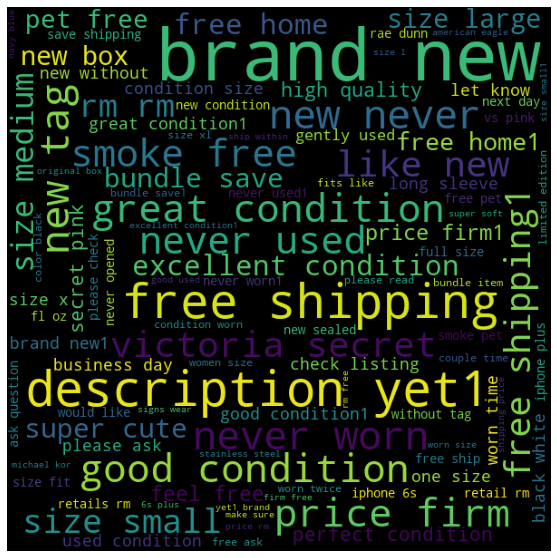

In [28]:
from wordcloud import WordCloud
word_cloud = WordCloud(width = 600, height = 600, stopwords=stopwords,min_font_size = 10).generate("1 ".join(train_data['item_description']))
plt.figure(figsize = (15, 10))
plt.imshow(word_cloud)
plt.axis('off')                                             
plt.show()

In [29]:
#data preparation
submission_df = pd.DataFrame(test_data['test_id'])
print(submission_df.shape)
submission_df.head()

(3460725, 1)


,test_id
0,0
1,1
2,2
3,3
4,4


In [30]:
#feature engineering
def get_name_first(name):
    
    name =  re.sub('[^A-Za-z0-9]+', ' ', name) .split()
    if len(name):
            return name[0].lower()
    return ''
        
        
train_data['name_first'] = train_data['name'].apply(get_name_first)
test_data['name_first'] = test_data['name'].apply(get_name_first)


     

def transform_test_data(base_col, feat_col):
    '''
    Returns feat_col column of test_data data by mapping from the values already calculated for the same column in train_data data
    
    Parameters:
    
    base_col: column based on which a transform(count, mean, median) has been applied
    
    feat_col: desired feature column after applying the transform
    '''
    #Create dictionary of feature values from train_data data
    di = pd.Series(train_data[feat_col].values, index=train_data[base_col].values).to_dict()
    
    #Map test_data data using dictionary and fill NAs with 0
    
    if base_col == 'item_condition_id':
        #No chance of NAs
        return test_data[base_col].map(di).astype(float)
        
    return test_data[base_col].map(di).fillna(0)

In [31]:
train_data['name_first_count'] = train_data.groupby('name_first')['name_first'].transform('count')
test_data['name_first_count'] = transform_test_data('name_first', 'name_first_count')

train_data['sub_category1_count'] = train_data.groupby('sub_category1')['sub_category1'].transform('count')
test_data['sub_category1_count'] = transform_test_data('sub_category1', 'sub_category1_count')

train_data['sub_category2_count'] = train_data.groupby('sub_category2')['sub_category2'].transform('count')
test_data['sub_category2_count'] = transform_test_data('sub_category2', 'sub_category2_count')

train_data['sub_category3_count'] = train_data.groupby('sub_category3')['sub_category3'].transform('count')
test_data['sub_category3_count'] = transform_test_data('sub_category3', 'sub_category3_count')

train_data['brand_name_count'] = train_data.groupby('brand_name')['brand_name'].transform('count')
test_data['brand_name_count'] = transform_test_data('brand_name', 'brand_name_count')


In [32]:
from sklearn.model_selection import train_test_split

y_tr = np.log1p(train_data['price'])
train_data.drop(['price'], axis=1, inplace=True)

train_df, cv_df , y_train, y_cv = train_test_split(train_data, y_tr, test_size=0.1, random_state=42)

print('Train size: {}, CV size: {}, Test size: {}' .format(train_df.shape, cv_df.shape, test_data.shape))

Train size: (1333494, 17), CV size: (148167, 17), Test size: (3460725, 17)


In [33]:
del train_data, y_tr
gc.collect()

2437

In [37]:
train_df['sub_category1'] = train_df['sub_category1'].fillna('')
cv_df['sub_category1'] = cv_df['sub_category1'].fillna('')
test_data['sub_category1'] = test_data['sub_category1'].fillna('')


In [39]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(lowercase=False, binary=True)

train_subcat1_oneHot = vectorizer.fit_transform(train_df['sub_category1'].values)
cv_subcat1_oneHot = vectorizer.transform(cv_df['sub_category1'].values)
test_subcat1_oneHot = vectorizer.transform(test_data['sub_category1'].values)

print("Shape of matrices after one hot encoding")
print(train_subcat1_oneHot.shape, "\n", cv_subcat1_oneHot.shape, "\n", test_subcat1_oneHot.shape)


Shape of matrices after one hot encoding
(1333494, 12) 
 (148167, 12) 
 (3460725, 12)


In [40]:
def clean_cat(cat_values):
    '''Takes categorical column values and returns list of cleaned categories'''
    categories = list(cat_values)

    cat_list = []
    for i in tqdm(categories):
        if not isinstance(i, str):
            i = ''
        i = re.sub('[^A-Za-z0-9]+', ' ', i)
        i = i.replace(' ', '')
        i = i.replace('&', '_')
        cat_list.append(i.strip())

    return cat_list


In [41]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
train_subcat1_oneHot = vectorizer.fit_transform(train_df['sub_category1'].values)

cv_subcat1_oneHot = vectorizer.transform(cv_df['sub_category1'].values)
test_subcat1_oneHot = vectorizer.transform(test_data['sub_category1'].values)

print("Shape of matrices after one hot encoding")
print(train_subcat1_oneHot.shape, "\n", cv_subcat1_oneHot.shape, "\n", test_subcat1_oneHot.shape)


Shape of matrices after one hot encoding
(1333494, 12) 
 (148167, 12) 
 (3460725, 12)


In [42]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
train_subcat2_oneHot = vectorizer.fit_transform(train_df['sub_category2'].values)

cv_subcat2_oneHot = vectorizer.transform(cv_df['sub_category2'].values)
test_subcat2_oneHot = vectorizer.transform(test_data['sub_category2'].values)

print("Shape of matrices after one hot encoding")
print(train_subcat2_oneHot.shape, "\n", cv_subcat2_oneHot.shape, "\n", test_subcat2_oneHot.shape)

Shape of matrices after one hot encoding
(1333494, 142) 
 (148167, 142) 
 (3460725, 142)


In [43]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
train_subcat3_oneHot = vectorizer.fit_transform(train_df['sub_category3'].values)

cv_subcat3_oneHot = vectorizer.transform(cv_df['sub_category3'].values)
test_subcat3_oneHot = vectorizer.transform(test_data['sub_category3'].values)

print("Shape of matrices after one hot encoding")
print(train_subcat3_oneHot.shape, "\n", cv_subcat3_oneHot.shape, "\n", test_subcat3_oneHot.shape)


Shape of matrices after one hot encoding
(1333494, 969) 
 (148167, 969) 
 (3460725, 969)


In [44]:
#tdif vectorization
vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=3, max_features=250000)

train_name_tfidf = vectorizer.fit_transform(train_df['name_first'].values)

cv_name_tfidf = vectorizer.transform(cv_df['name_first'].values)
test_name_tfidf = vectorizer.transform(test_data['name_first'].values)

print("Shape of matrices after vectorization")
print(train_name_tfidf.shape, "\n", cv_name_tfidf.shape, "\n", test_name_tfidf.shape)

Shape of matrices after vectorization
(1333494, 13949) 
 (148167, 13949) 
 (3460725, 13949)


In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=5, max_features=500000)

train_description_tfidf = vectorizer.fit_transform(train_df['item_description'].values)

cv_description_tfidf = vectorizer.transform(cv_df['item_description'].values)
test_description_tfidf = vectorizer.transform(test_data['item_description'].values)

print("Shape of matrices after vectorization")
print(train_description_tfidf.shape, "\n", cv_description_tfidf.shape, "\n", test_description_tfidf.shape)

In [46]:
cols = set(train_df.columns.values) - {'train_id'}
skip_cols = {'item_condition_id', 'brand_name',
  'shipping', 'item_description', 'sub_category1',
  'sub_category2', 'sub_category3', 'name_first', 
  'category_name', 'name'}

cols_to_normalize = cols - skip_cols
print("Normalizing following columns: ", cols_to_normalize)

def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (feature_name in cols_to_normalize):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1


Normalizing following columns:  {'sub_category1_count', 'sub_category3_count', 'brand_name_count', 'sub_category2_count', 'count_stopwords', 'name_first_count'}


In [ ]:
train_df.head()

In [ ]:
train_normalized = normalize(train_df)
cv_normalized = normalize(cv_df)
test_normalized = normalize(test_data)

In [ ]:
del train_df, cv_df, test_data
gc.collect()

In [ ]:
X_tr = train_normalized[list(cols_to_normalize)]
X_val = cv_normalized[list(cols_to_normalize)]
X_te = test_normalized[list(cols_to_normalize)]

X_tr.head(2)

In [ ]:
from scipy.sparse import csr_matrix

# Storing categorical features to sparse matrix

X_tr_cat = csr_matrix(pd.get_dummies(train_normalized[['item_condition_id', 'shipping']], sparse=True).values)

X_cv_cat = csr_matrix(pd.get_dummies(cv_normalized[['item_condition_id', 'shipping']], sparse=True).values)

X_te_cat = csr_matrix(pd.get_dummies(test_normalized[['item_condition_id', 'shipping']], sparse=True).values)

print(X_tr_cat.shape, X_cv_cat.shape, X_te_cat.shape)


In [ ]:
del train_normalized, cv_normalized, test_normalized
gc.collect()

In [ ]:
from scipy.sparse import hstack

# stack all categorical and text sparse matrices

train_sparse = hstack((train_brand_oneHot, train_subcat1_oneHot, train_subcat2_oneHot, train_subcat3_oneHot, \
               train_name_tfidf, train_description_tfidf, X_tr_cat)).tocsr()

cv_sparse = hstack((cv_brand_oneHot, cv_subcat1_oneHot, cv_subcat2_oneHot, cv_subcat3_oneHot, \
               cv_name_tfidf, cv_description_tfidf, X_cv_cat)).tocsr()

test_sparse = hstack((test_brand_oneHot, test_subcat1_oneHot, test_subcat2_oneHot, test_subcat3_oneHot, \
               test_name_tfidf, test_description_tfidf, X_te_cat)).tocsr()


     

print(train_sparse.shape, cv_sparse.shape, test_sparse.shape)

In [ ]:
# stack dense feature matrix with categorical and text vectors

X_train = hstack((X_tr.values, train_sparse)).tocsr()

X_cv = hstack((X_val.values, cv_sparse)).tocsr()

X_test = hstack((X_te.values, test_sparse)).tocsr()


In [ ]:
print('Train size: {}, CV size: {}, Test size: {}' .format(X_train.shape, X_cv.shape, X_test.shape))


In [ ]:
del vectorizer
del train_brand_oneHot, train_subcat1_oneHot, train_subcat2_oneHot, train_subcat3_oneHot, \
            train_name_tfidf, train_description_tfidf, X_tr_cat

del cv_brand_oneHot, cv_subcat1_oneHot, cv_subcat2_oneHot, cv_subcat3_oneHot, cv_name_tfidf, cv_description_tfidf, X_cv_cat

del test_brand_oneHot, test_subcat1_oneHot, test_subcat2_oneHot, test_subcat3_oneHot, \
               test_name_tfidf, test_description_tfidf, X_te_cat
gc.collect()

## Ridge Regression

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from math import sqrt
from sklearn.linear_model import Ridge

In [ ]:
alpha = [1, 2, 3, 3.5, 4, 4.5, 5, 6, 7] 
cv_rmsle_array=[] 
for i in tqdm(alpha):
    model = Ridge(solver="sag", random_state=42, alpha=i)
    model.fit(X_train, y_train)
    preds_cv = model.predict(X_cv)
    cv_rmsle_array.append(sqrt(mse(y_cv, preds_cv)))

for i in range(len(cv_rmsle_array)):
    print ('RMSLE for alpha = ',alpha[i],'is',cv_rmsle_array[i])
    
best_alpha = np.argmin(cv_rmsle_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_rmsle_array)
ax.scatter(alpha, cv_rmsle_array)
for i, txt in enumerate(np.round(cv_rmsle_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_rmsle_array[i]))

plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()


In [ ]:
print("Best alpha: ",  alpha[best_alpha])
model = Ridge(solver="sag", random_state=42, alpha=alpha[best_alpha])
model.fit(X_train, y_train)
ridge_preds_tr = model.predict(X_train)
ridge_preds_cv = model.predict(X_cv)
ridge_preds_te = model.predict(X_test)

print('Train RMSLE:', sqrt(mse(y_train, ridge_preds_tr)))

ridge_rmsle = sqrt(mse(y_cv, ridge_preds_cv))
print("Cross validation RMSLE: ", ridge_rmsle)


## Support Vector Model

In [ ]:
from math import sqrt
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


from sklearn.model_selection import RandomizedSearchCV 
from scipy.stats import randint as sp_randint
from scipy.stats import uniform



In [ ]:
c_param = [0.01, 0.03, 0.1, 0.3, 1, 3, 10]
cv_rmsle_array=[]

for i in c_param:
    model = SVR(C=i, max_iter=200)
    model.fit(X_train, y_train)
    preds_cv = model.predict(X_cv)
    cv_err = sqrt(mse(y_cv, preds_cv))
    cv_rmsle_array.append(cv_err)

    print('RMSLE for C=',i, 'is', cv_err)

best_C = np.argmin(cv_rmsle_array)

fig, ax = plt.subplots()
ax.plot(c_param, cv_rmsle_array)
ax.scatter(c_param, cv_rmsle_array)
for i, txt in enumerate(np.round(cv_rmsle_array,3)):
    ax.annotate((c_param[i],np.round(txt,3)), (c_param[i],cv_rmsle_array[i]))
plt.title("Cross Validation Error for each C")
plt.xlabel("C")
plt.ylabel("Error")
plt.show()


In [ ]:
#Hyper parameter tuning
best_C = c_param[best_C]
print('Best C: ', best_C)
model = SVR(C=best_C, max_iter=200)
model.fit(X_train, y_train)


In [ ]:
svr_preds_tr = model.predict(X_train)
svr_preds_cv = model.predict(X_cv)
print('Train RMSLE:', sqrt(mse(y_train, svr_preds_tr)))

svr_rmsle = sqrt(mse(y_cv, svr_preds_cv))
print("Cross validation RMSLE: ", svr_rmsle)
